The purpose of this notebook is to study the relationships between volatility and social media spikes using GARCH-X. GARCH-X can handle temporal changes to variance (volatility) to make predictions, which makes it a reasonable candidate for modelling. We use step-by-step refitting and allows for influences from our predictors. 

Code for GARCH-X was written with help from templates and AI error correction. This model is valid, as it is fit on simple returns (a.k.a percent change) and the target is absolute simple returns. 

In [118]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from arch import arch_model
import matplotlib.pyplot as plt

df = pd.read_csv('daily_spike_vs_none_1.5sigma_all.csv')
# Remove entries where Ticker is "WBA" -- a problematic set. 
df = df[df['Ticker'] != 'WBA'].reset_index(drop=True)
df = df.sort_values('Date').reset_index(drop=True)
groups = df.groupby('Ticker')


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def fit_rolling_garch_x_with_stats(ticker, ticker_df, exog_vars, initial_train_ratio=0.7, k=10):

    ticker_df = ticker_df.sort_values('Date').reset_index(drop=True)
    #convert to numeric and drop na
    ticker_df['actual_volatility'] = pd.to_numeric(ticker_df['actual_volatility'], errors='coerce')
    #scale for numeric stability based on automated recommendation
    ticker_df['returns'] = ticker_df['actual_volatility'] * 100

    #lag predictors by one day
    for var in exog_vars:
        ticker_df[f'{var}_lag1'] = ticker_df[var].shift(1)
    ticker_df.dropna(inplace=True)

    n = len(ticker_df)
    #temporal train/test split
    initial_train_size = int(initial_train_ratio * n)

    predicted_vol = []
    train_errors = []
    test_errors = []
    p_values_per_refit = {var: [] for var in exog_vars}
    refit_points = []

    model = None
    res = None
    
    #step-by-step refits of GARCH-X
    for i in range(initial_train_size, n):
        train_slice = ticker_df.iloc[:i]

        if (i - initial_train_size) % k == 0 or i == initial_train_size:
            model = arch_model(
                train_slice['returns'],
                mean='ARX',
                lags=0,
                vol='Garch',
                p=1, q=1,
                dist='normal',
                x=train_slice[[f'{var}_lag1' for var in exog_vars]]
            )
            res = model.fit(disp='off')

            # Store refit point
            refit_points.append(ticker_df['Date'].iloc[i])

            # Save p-values for each exog var aka hypothesis tests
            for var in exog_vars:
                p = res.pvalues.get(f'{var}_lag1', np.nan)
                p_values_per_refit[var].append(p)

            # Calculate train errors on hold-back portion or full train slice returns and conditional variances
            train_pred_vol = np.sqrt(res.conditional_volatility)
            mse_train = mean_squared_error(train_slice['returns'].abs(), train_pred_vol)
            mae_train = mean_absolute_error(train_slice['returns'].abs(), train_pred_vol)
            train_errors.append((mse_train, mae_train))

            # Calculate test errors on all predictions so far, if any
            if predicted_vol:
                actual_test = ticker_df['returns'].abs().iloc[initial_train_size:i]
                mse_test = mean_squared_error(actual_test, predicted_vol)
                mae_test = mean_absolute_error(actual_test, predicted_vol)
                test_errors.append((mse_test, mae_test))
            else:
                test_errors.append((np.nan, np.nan))

        # Forecast next volatility step
        test_point = ticker_df.iloc[i]
        next_exog_vals = test_point[[f'{var}_lag1' for var in exog_vars]].to_numpy(dtype=np.float64)
        next_exog = next_exog_vals.reshape(-1, 1, 1)

        forecast = res.forecast(x=next_exog, horizon=1)
        predicted_var = forecast.variance.values[-1, 0]
        predicted_vol.append(np.sqrt(predicted_var))

    actual_vol = ticker_df['returns'].abs().iloc[initial_train_size:].values
    dates = ticker_df['Date'].iloc[initial_train_size:]

    # Package results
    results = {
        'dates': dates,
        'actual_vol': actual_vol,
        'predicted_vol': predicted_vol,
        'refit_points': refit_points,
        'p_values': p_values_per_refit,
        'train_errors': train_errors,
        'test_errors': test_errors
    }
    return results

# Visualization helper functions
def plot_p_values_over_time(results):
    plt.figure(figsize=(12, 6))
    for var, pvals in results['p_values'].items():
        plt.plot(results['refit_points'], pvals, label=var)
    plt.axhline(0.05, color='red', linestyle='--', label="Significance Threshold (0.05)")
    plt.title(f'Exogenous Variables p-values Over Rolling Refits ({ticker})')
    plt.xlabel('Date')
    plt.ylabel('p-value')
    plt.legend()
    plt.yscale('log')
    plt.show()

#plot train/test errors
def plot_train_test_errors(results):
    train_mse = [e[0] for e in results['train_errors']]
    test_mse = [e[0] for e in results['test_errors']]
    train_mae = [e[1] for e in results['train_errors']]
    test_mae = [e[1] for e in results['test_errors']]

    plt.figure(figsize=(12, 6))
    plt.plot(results['refit_points'], train_mse, label='Train MSE')
    plt.plot(results['refit_points'], test_mse, label='Test MSE')
    plt.plot(results['refit_points'], train_mae, label='Train MAE', linestyle='dashed')
    plt.plot(results['refit_points'], test_mae, label='Test MAE', linestyle='dashed')
    plt.title(f'Train vs Test Forecast Errors Over Time ({ticker})')
    plt.xlabel('Date')
    plt.ylabel('Error')
    plt.legend()
    plt.show()

#plot GARCH-X fitting results
def plot_garch_x_results(results):
    plt.figure(figsize=(12, 6))
    plt.plot(results['dates'], results['actual_vol'], label='Actual Volatility', color='blue')
    plt.plot(results['dates'], results['predicted_vol'], label='Predicted Volatility', color='orange')
    plt.title(f'GARCH-X Model: Actual vs Predicted Volatility ({ticker})')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()


No significant spike effect found for AAPL. Skipping plots.
No well-fitting model found for AAPL. R2: -0.3447.

****Significant spike effect found for ABBV. Plotting results.*****



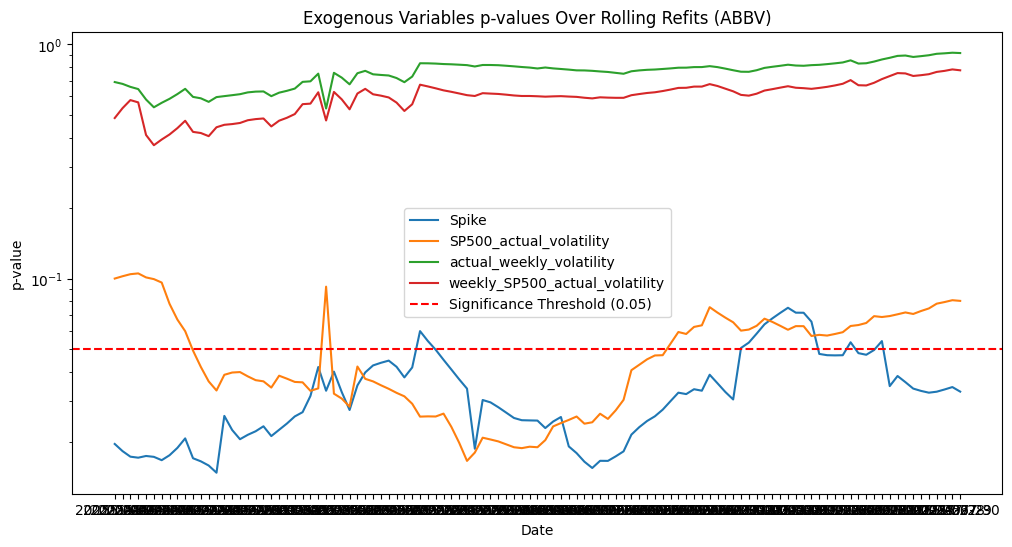

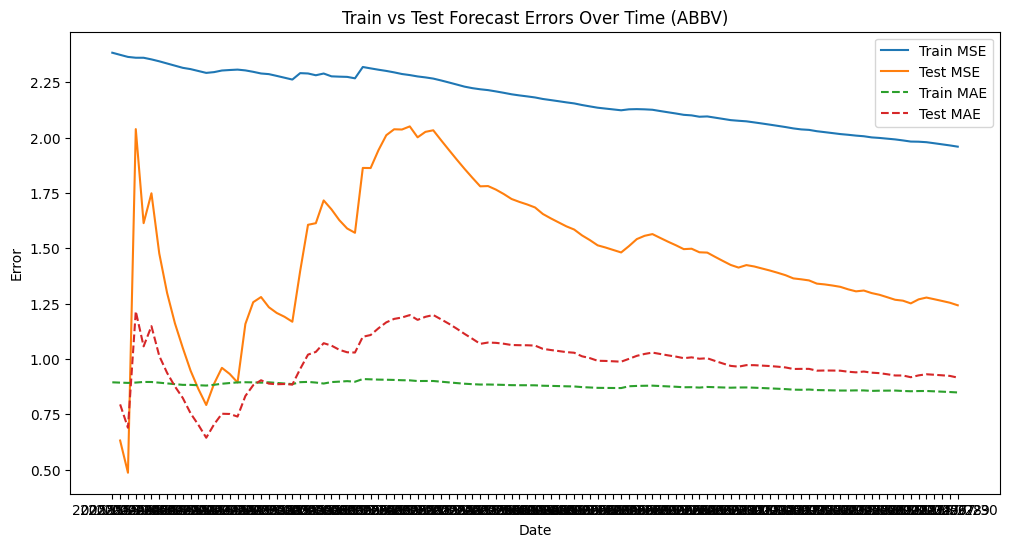

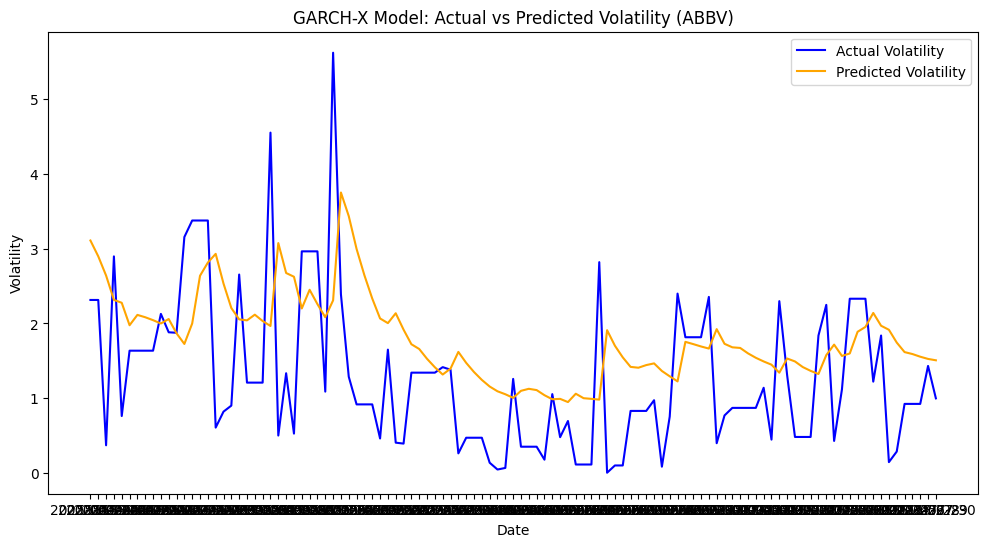

No well-fitting model found for ABBV. R2: -0.1928.

No significant spike effect found for AMZN. Skipping plots.
No well-fitting model found for AMZN. R2: 0.0878.

No significant spike effect found for BA. Skipping plots.
No well-fitting model found for BA. R2: -0.8372.

No significant spike effect found for BAC. Skipping plots.
No well-fitting model found for BAC. R2: -0.3177.

No significant spike effect found for C. Skipping plots.
No well-fitting model found for C. R2: -0.2642.

No significant spike effect found for CAH. Skipping plots.
No well-fitting model found for CAH. R2: -0.2120.

No significant spike effect found for CI. Skipping plots.
No well-fitting model found for CI. R2: -0.0702.

No significant spike effect found for CMCSA. Skipping plots.
No well-fitting model found for CMCSA. R2: -0.9540.

No significant spike effect found for CNC. Skipping plots.
No well-fitting model found for CNC. R2: -0.8233.

No significant spike effect found for COR. Skipping plots.
No well-fitt

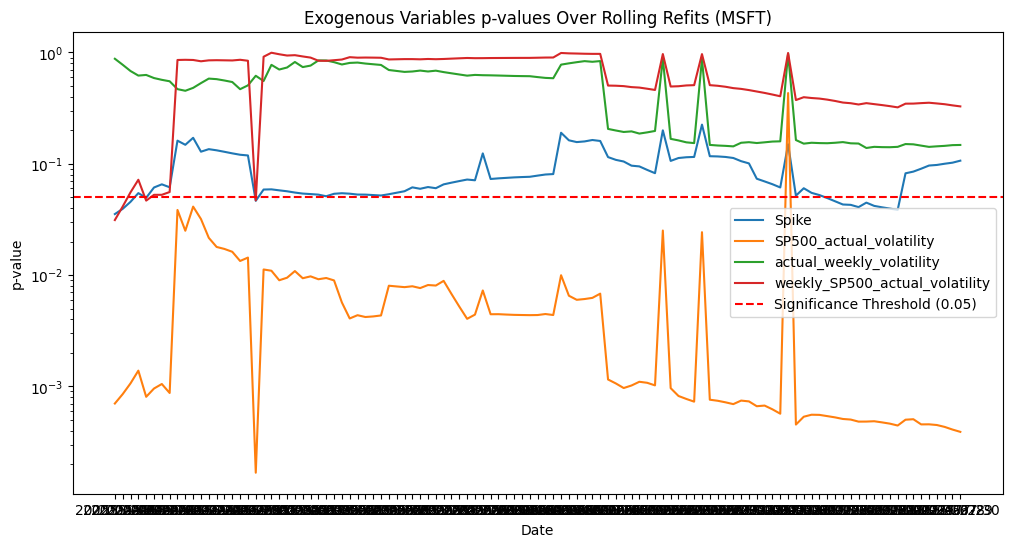

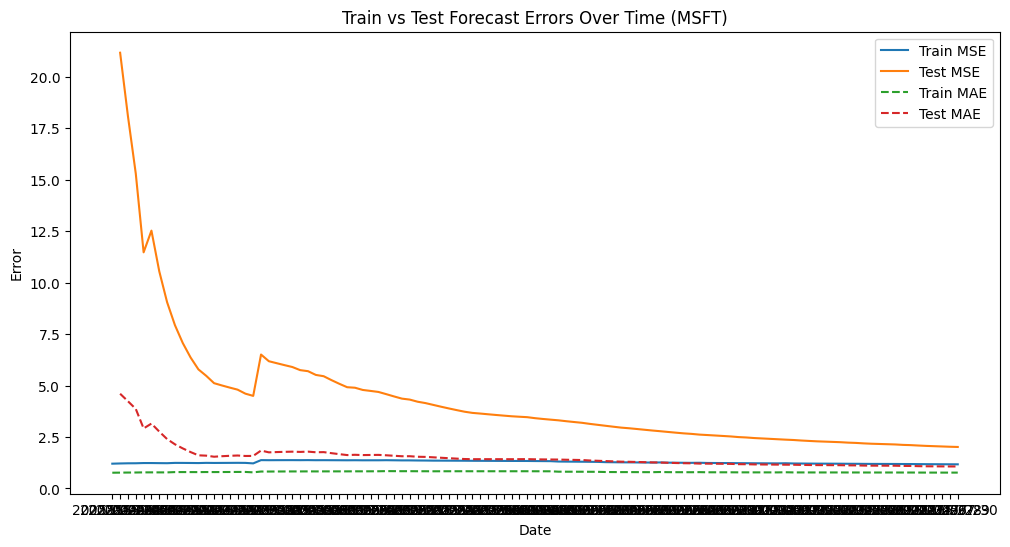

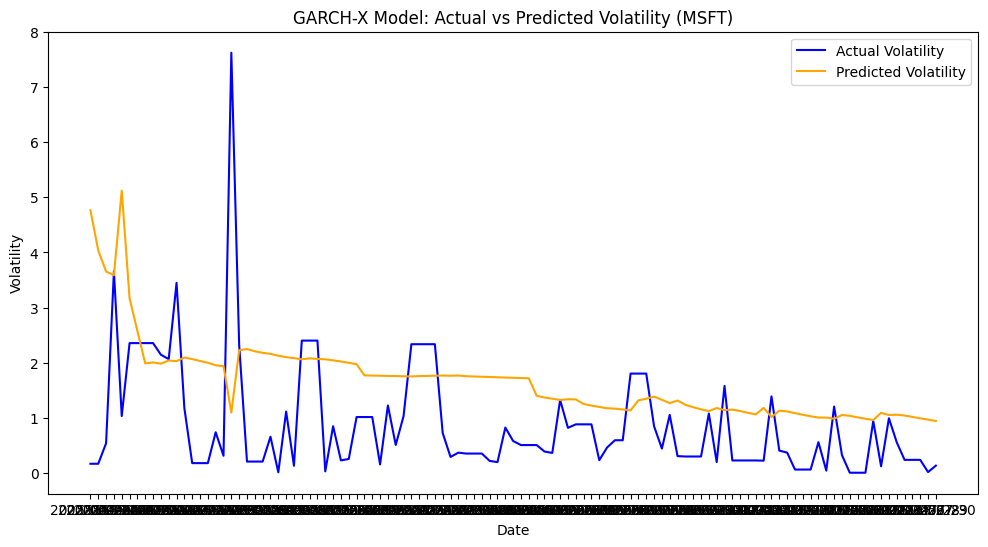

No well-fitting model found for MSFT. R2: -0.8420.

No significant spike effect found for NVDA. Skipping plots.
No well-fitting model found for NVDA. R2: -0.4710.

****Significant spike effect found for PEP. Plotting results.*****



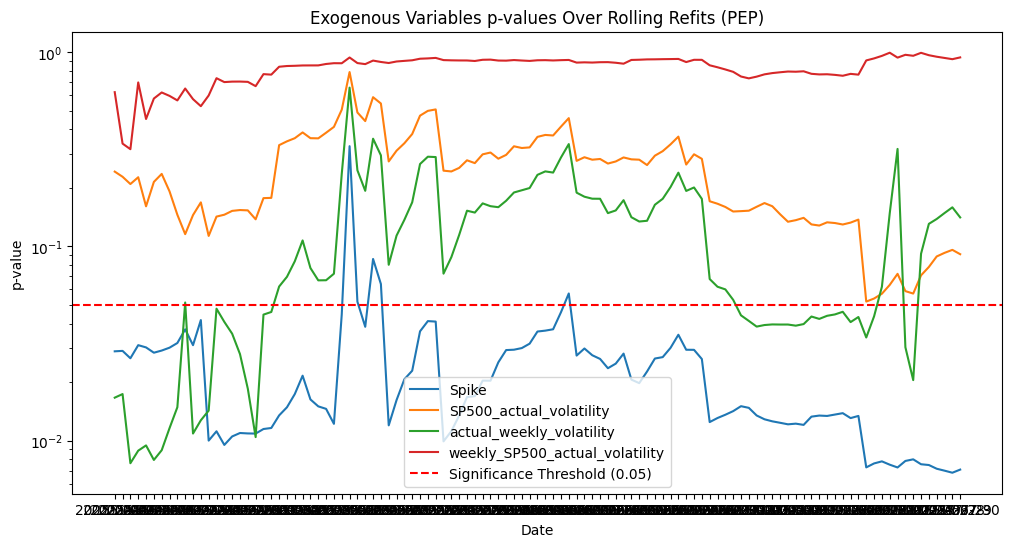

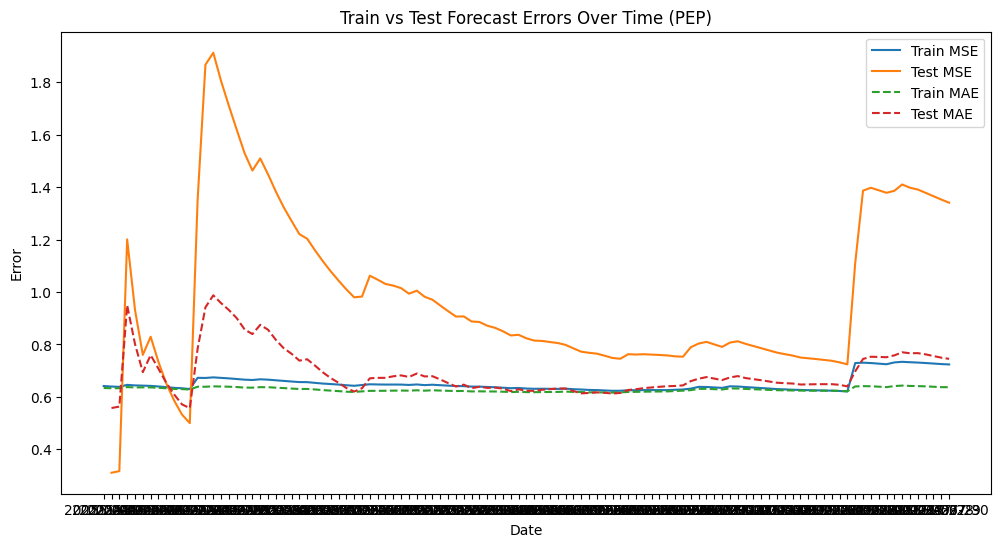

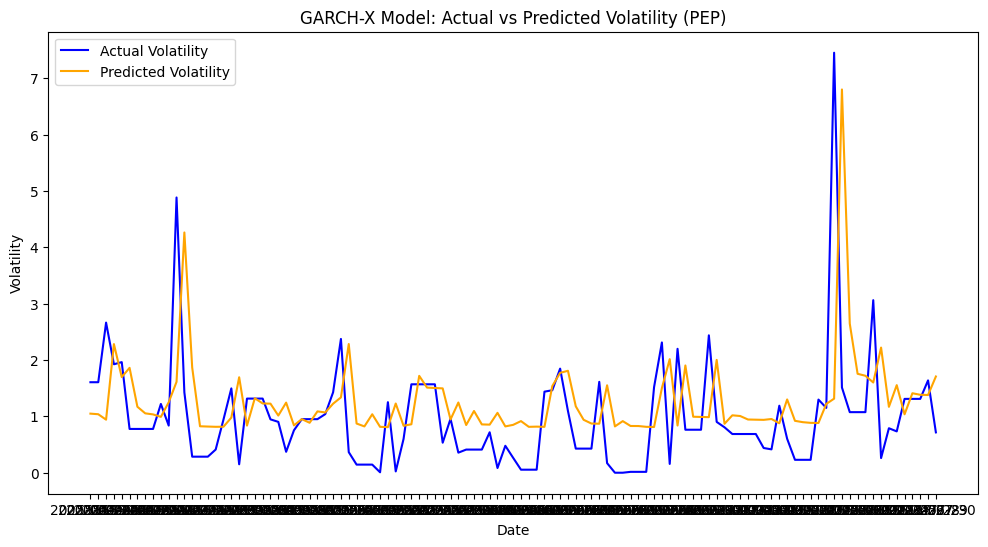

No well-fitting model found for PEP. R2: -0.4021.

No significant spike effect found for PFE. Skipping plots.
No well-fitting model found for PFE. R2: -0.0580.

****Significant spike effect found for PG. Plotting results.*****



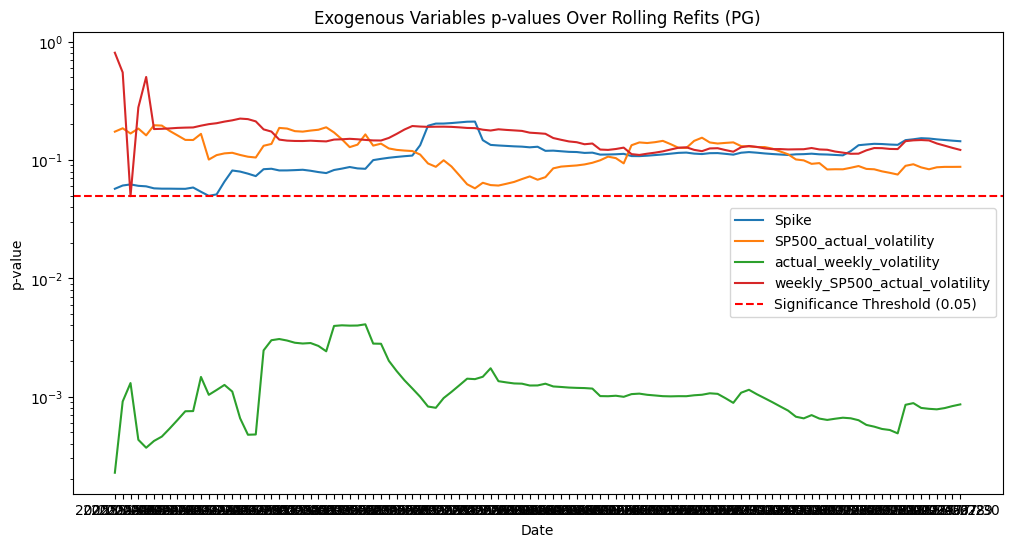

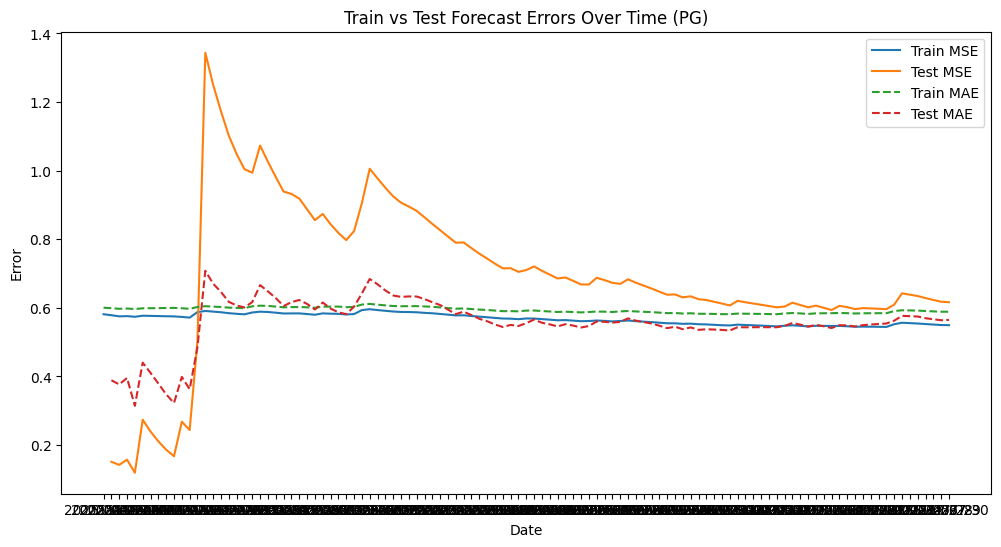

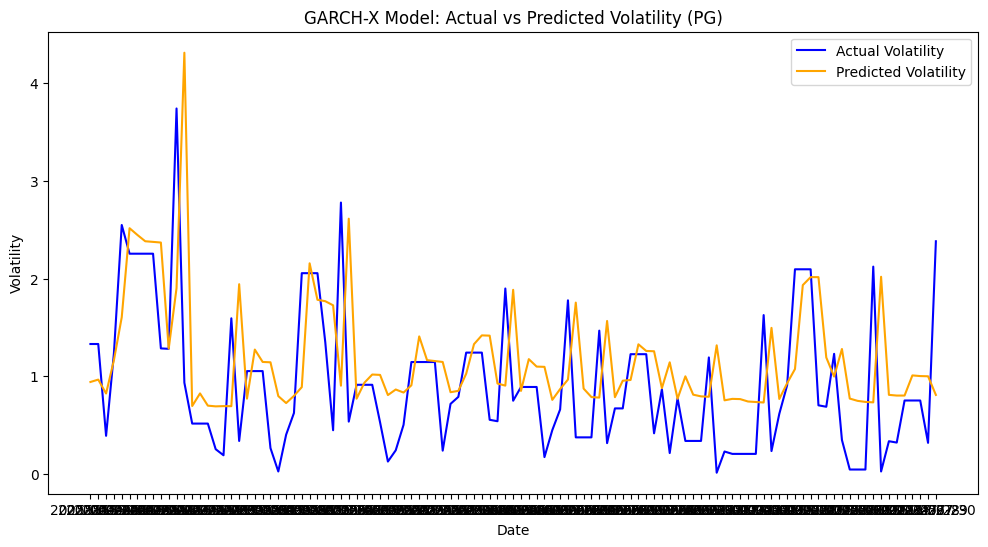

No well-fitting model found for PG. R2: -0.2216.

No significant spike effect found for SBUX. Skipping plots.
No well-fitting model found for SBUX. R2: -0.1624.

No significant spike effect found for T. Skipping plots.
No well-fitting model found for T. R2: -0.0431.

No significant spike effect found for TGT. Skipping plots.
No well-fitting model found for TGT. R2: -0.4225.

No significant spike effect found for TSLA. Skipping plots.
No well-fitting model found for TSLA. R2: -0.1628.

No significant spike effect found for UNH. Skipping plots.
No well-fitting model found for UNH. R2: -0.2624.

No significant spike effect found for UPS. Skipping plots.
No well-fitting model found for UPS. R2: -0.2496.

No significant spike effect found for VZ. Skipping plots.
No well-fitting model found for VZ. R2: 0.0357.

****Significant spike effect found for WFC. Plotting results.*****



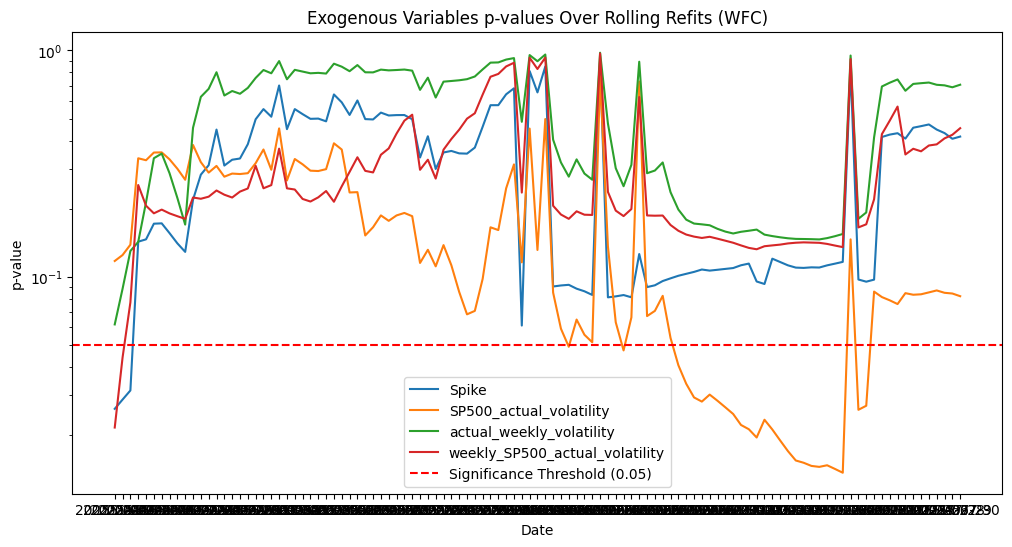

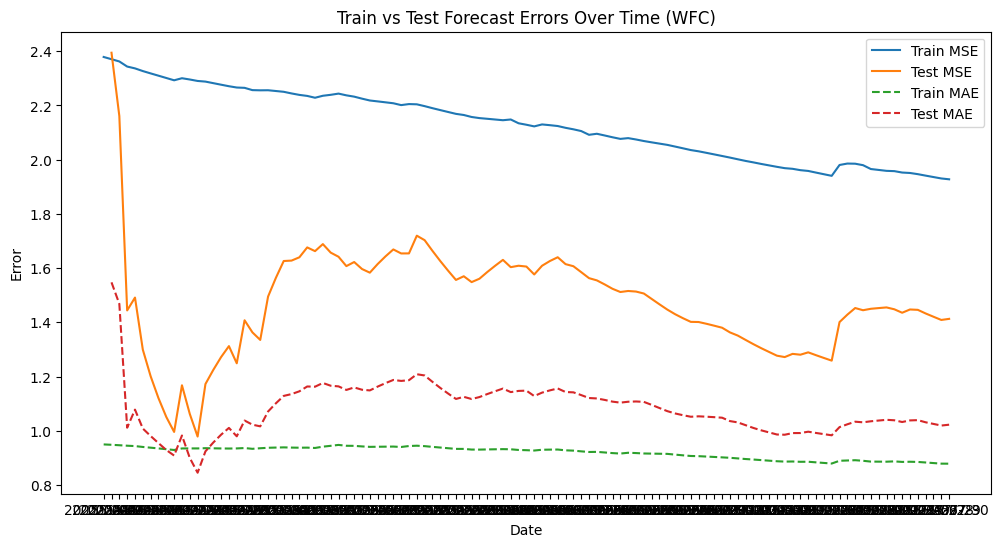

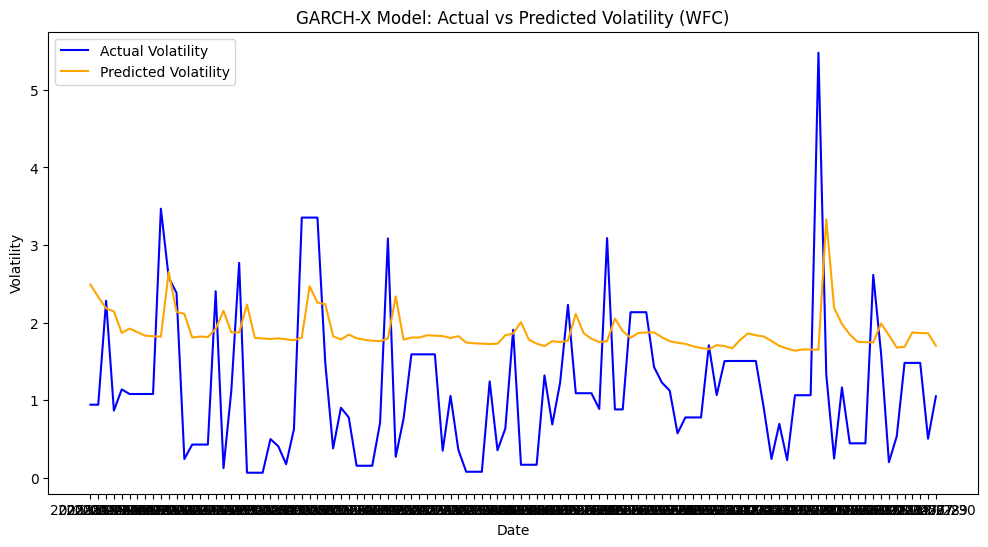

No well-fitting model found for WFC. R2: -0.6219.

No significant spike effect found for WMT. Skipping plots.
No well-fitting model found for WMT. R2: -1.3555.

No significant spike effect found for XOM. Skipping plots.
No well-fitting model found for XOM. R2: -0.1251.



In [ ]:
#Run for each ticker, only plotting the results if the spike p value is significant
for ticker, group in groups:
    exog_vars = ['Spike', 'SP500_actual_volatility', 'actual_weekly_volatility', 'weekly_SP500_actual_volatility']
    results = fit_rolling_garch_x_with_stats(ticker, group, exog_vars, initial_train_ratio=0.7, k=1)

    # Check if any p-value for 'sentiment_score' is below 0.05
    if any(p < 0.05 for p in results['p_values']['Spike']):
        print(f"****Significant spike effect found for {ticker}. Plotting results.*****\n")
        plot_p_values_over_time(results)
        plot_train_test_errors(results)
        plot_garch_x_results(results)
    else:
        print(f"No significant spike effect found for {ticker}. Skipping plots.")
    #Check if there is a well-fitting model by calculating overall MSE, MAE, R2
    actual_volatility = results['actual_vol']
    predicted_volatility = results['predicted_vol']
    mse = mean_squared_error(actual_volatility, predicted_volatility)
    mae = mean_absolute_error(actual_volatility, predicted_volatility)
    r2 = r2_score(actual_volatility, predicted_volatility)
    #flag if there is a well-fitting model
    if r2 > 0.1:
        print(f"Well-fitting model found for {ticker} with R2: {r2:.4f}.")
       # print(f"MSE: {mse:.6f}, MAE: {mae:.6f}, R2: {r2:.4f}\n")
    else:
        print(f"No well-fitting model found for {ticker}. R2: {r2:.4f}.\n")
    



Given these results, the only companies which we could reasonably claim have non-trivial Spike influences are PEP and ABBV. These can be investigated further by eliminating the Spike variable and rerunning the model. 

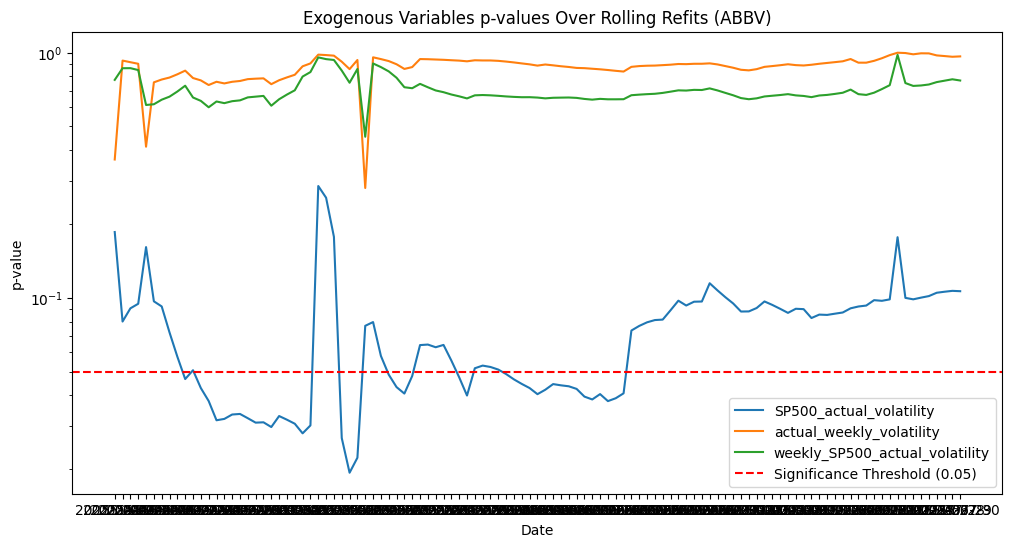

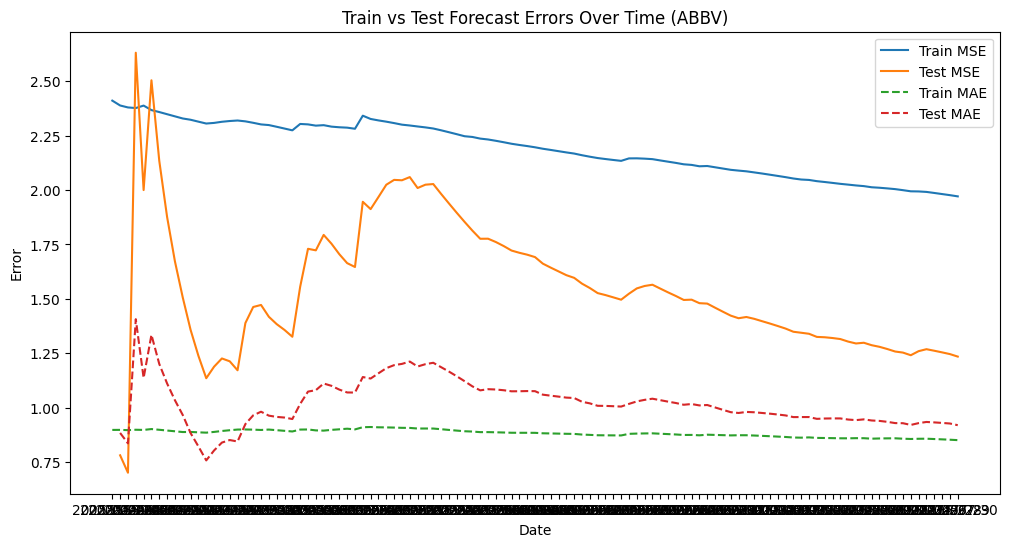

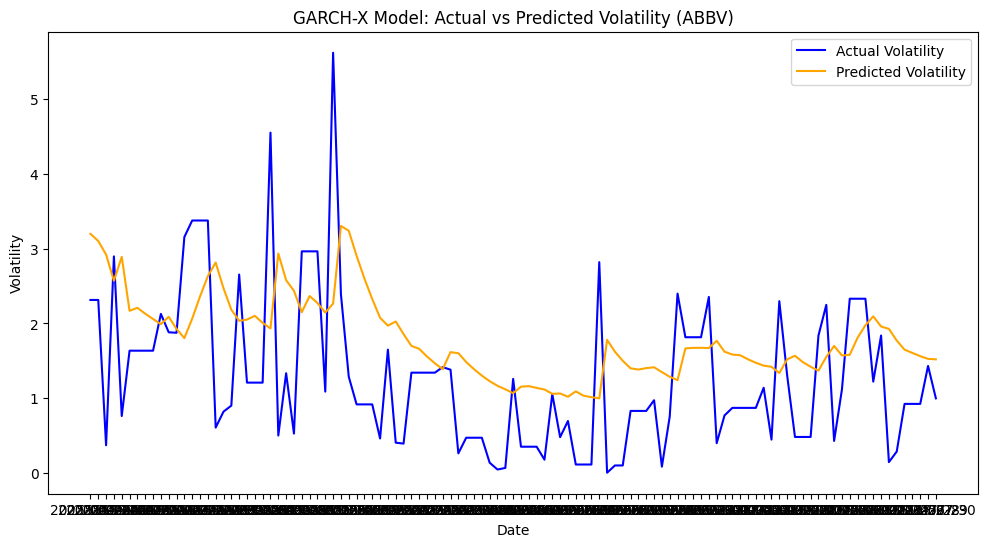

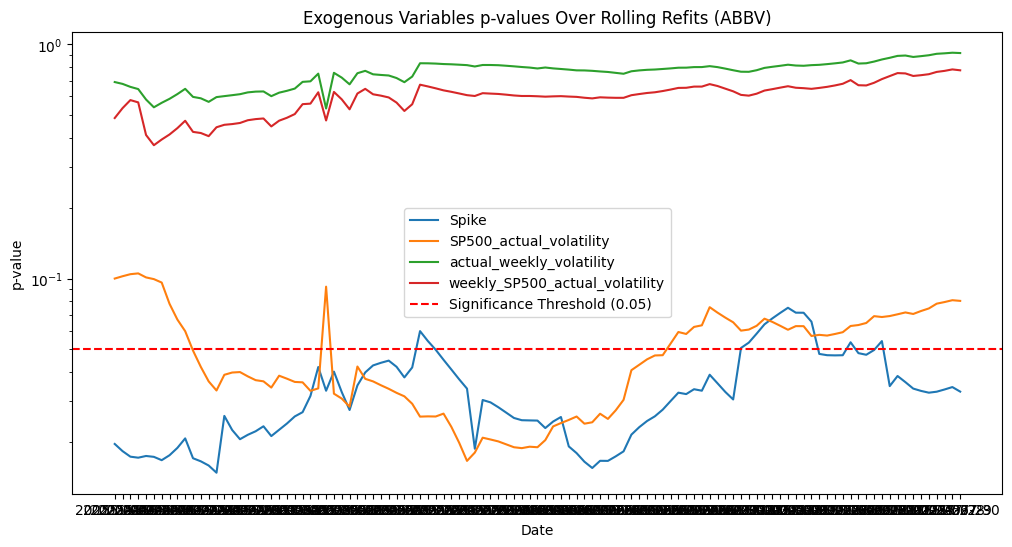

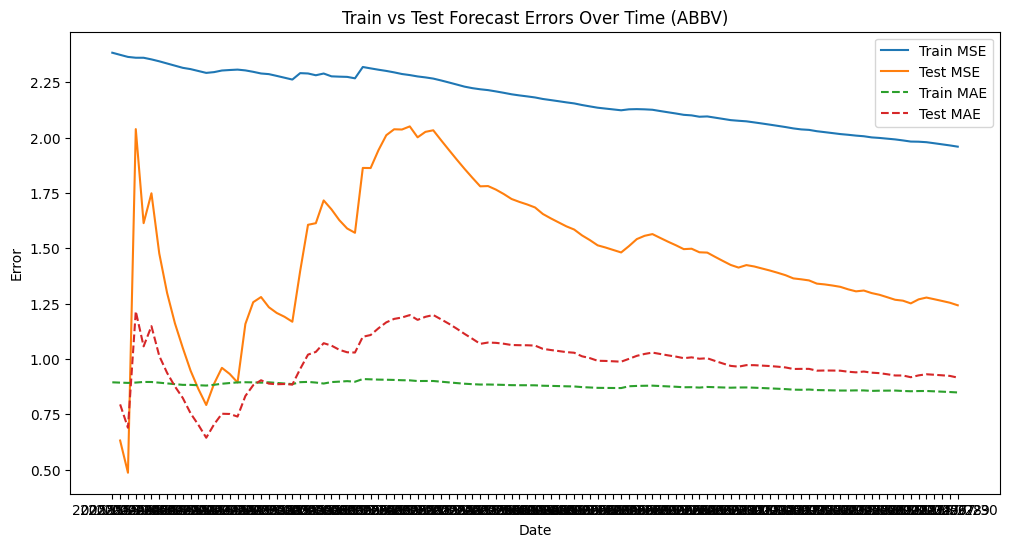

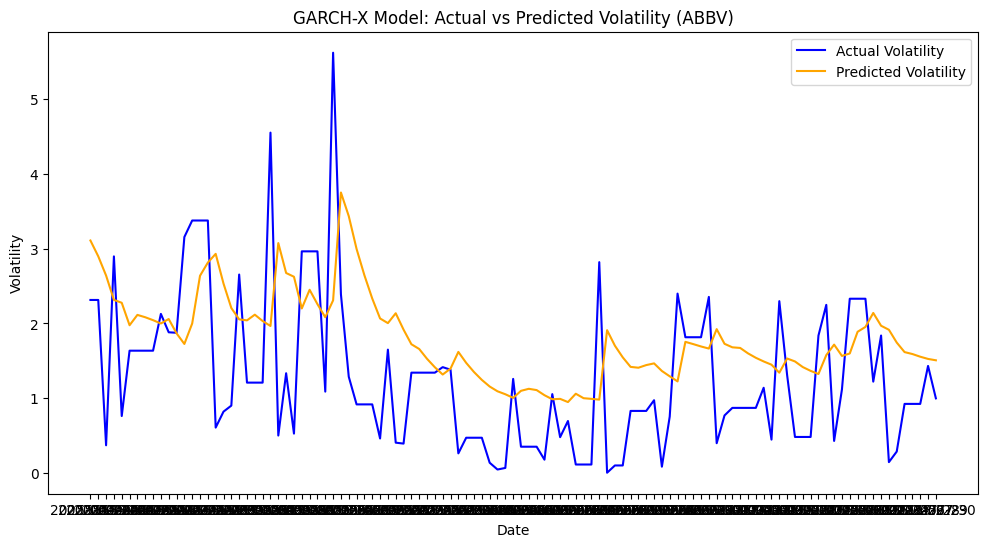

(No Spike) MSE: 1.225834, MAE: 0.915734, R2: -0.1855

(With Spike) MSE: 1.233318, MAE: 0.911751, R2: -0.1928



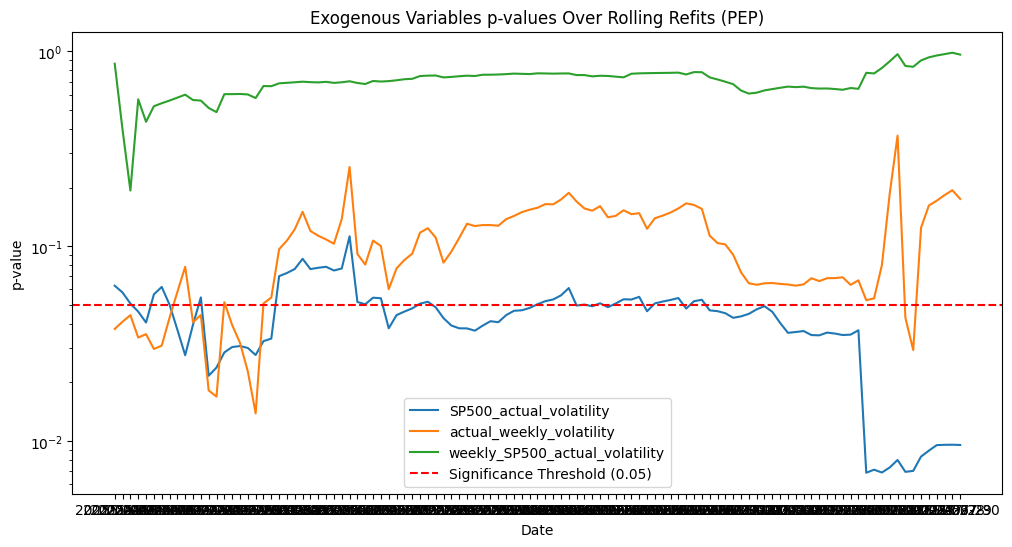

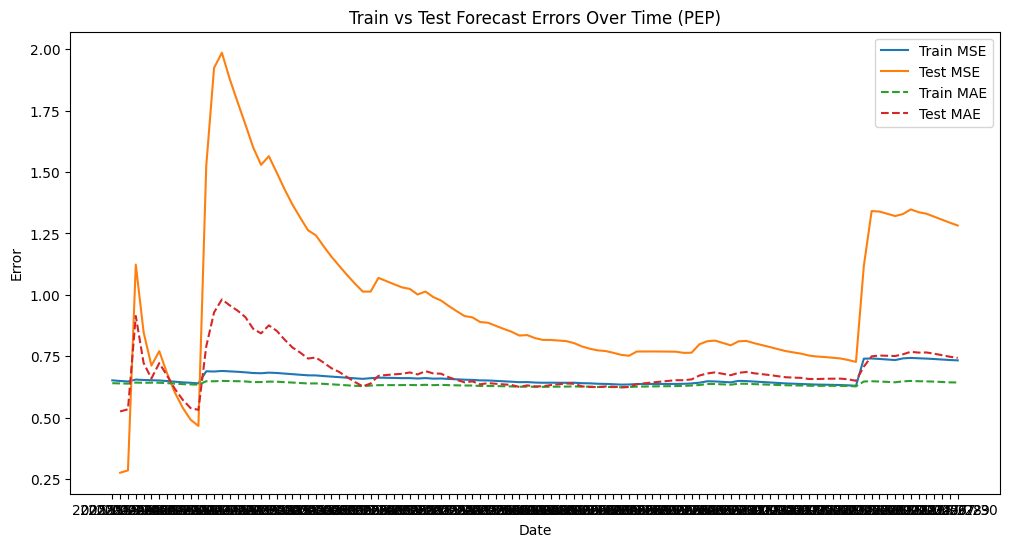

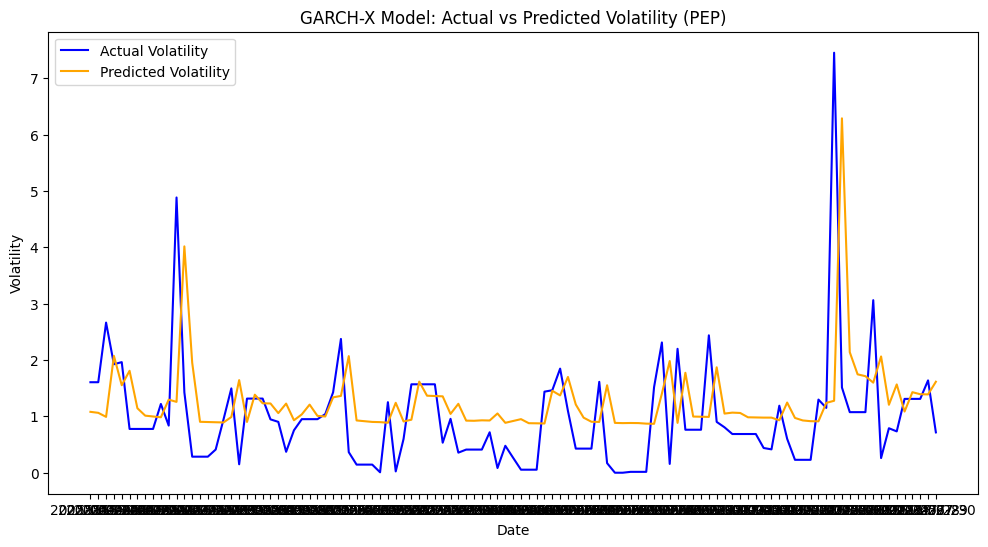

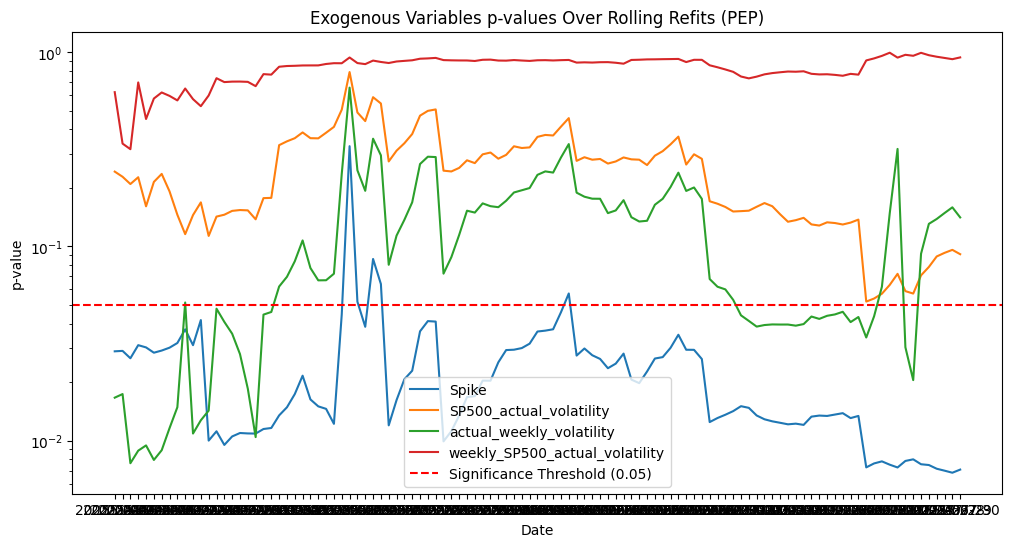

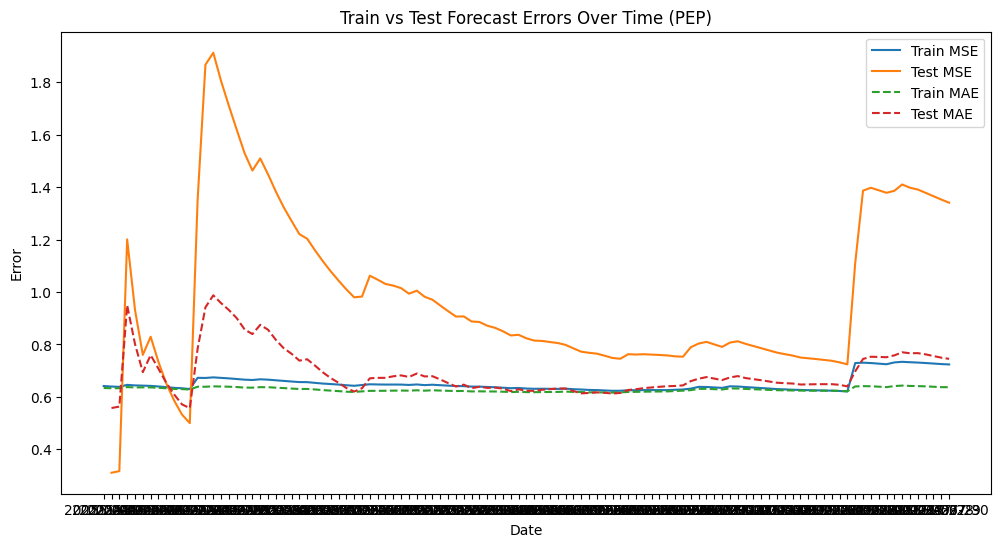

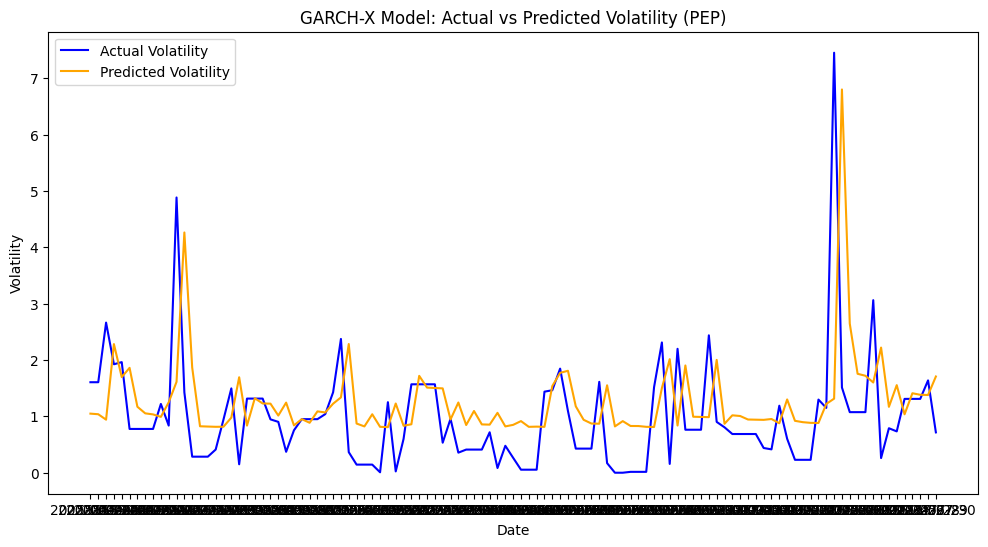

(No Spike) MSE: 1.277843, MAE: 0.745031, R2: -0.3399

(With Spike) MSE: 1.337197, MAE: 0.747182, R2: -0.4021



In [124]:
#Run without Spike for ABBV and PEP
df = pd.read_csv('daily_spike_vs_none_1.5sigma_all.csv')

# Keep only ABBV and PEP
df = df[df['Ticker'].isin(['ABBV', 'PEP'])].reset_index(drop=True)
df = df.sort_values('Date').reset_index(drop=True)
groups = df.groupby('Ticker')

for ticker, group in groups:
    exog_vars = ['SP500_actual_volatility', 'actual_weekly_volatility', 'weekly_SP500_actual_volatility']
    results = fit_rolling_garch_x_with_stats(ticker, group, exog_vars, initial_train_ratio=0.7, k=1)
    plot_p_values_over_time(results)
    plot_train_test_errors(results)
    plot_garch_x_results(results)
    #Calculate overall MSE, MAE, R2
    actual_volatility = results['actual_vol']
    predicted_volatility = results['predicted_vol']
    mse = mean_squared_error(actual_volatility, predicted_volatility)
    mae = mean_absolute_error(actual_volatility, predicted_volatility)
    r2 = r2_score(actual_volatility, predicted_volatility)
    

    exog_vars = ['Spike','SP500_actual_volatility', 'actual_weekly_volatility', 'weekly_SP500_actual_volatility']
    results = fit_rolling_garch_x_with_stats(ticker, group, exog_vars, initial_train_ratio=0.7, k=1)
    plot_p_values_over_time(results)
    plot_train_test_errors(results)
    plot_garch_x_results(results)
    #Check if there is a well-fitting model by calculating overall MSE, MAE, R2
    actual_volatility = results['actual_vol']
    predicted_volatility = results['predicted_vol']
    mse1 = mean_squared_error(actual_volatility, predicted_volatility)
    mae1 = mean_absolute_error(actual_volatility, predicted_volatility)
    r21 = r2_score(actual_volatility, predicted_volatility)
    print(f"(No Spike) MSE: {mse:.6f}, MAE: {mae:.6f}, R2: {r2:.4f}\n")
    print(f"(With Spike) MSE: {mse1:.6f}, MAE: {mae1:.6f}, R2: {r21:.4f}\n")





Conclusions: GARCH-X, in general, does a poor job predicting volatility with these selected predictors. This is not unusual for this model and target value. More robust versions of GARCH may make better fits, but in general we are looking at signal from the spike predictor. The addition of Spike in cases where Spike was statistically significant did not improve the overall fit of the model. 